In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scipy.io

from config import Config
import utils
import model as modellib
import visualize
from model import log
import prostate

%matplotlib inline

# GPU to use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


Using TensorFlow backend.


In [2]:
dataset_dir = "/scratch/wenyuan/Mask_RCNN_On_Pathology/Data_Pre_Processing/cedars-224"
held_out_set = 4
mean_pixel = prostate.Mean_pixel(dataset_dir, held_out_set)
class InferenceConfig(prostate.ProstateConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.5
    DETECTION_NMS_THRESHOLD = 1     
    MEAN_PIXEL = np.array(mean_pixel)
    IMAGE_MAX_DIM = 512
    IMAGE_MIN_DIM = 512

inference_config = InferenceConfig()
inference_config.display()
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path, find a trained weights specified by epoch and held_out_set or find last trained weights

# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()[1]
# model_path = model.find_specific(epoch = 9, held_out_set = 4)[1]
# model_path = model.find_specific(epoch = 75, held_out_set = held_out_set)[1]
model_path = model.find_specific(epoch = 70)[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        1
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  512
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 193.97800579  120.89113632  183.79060979]
MINI_MASK_SHAPE                (56, 56)
NAME                           prostate
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
PO

In [3]:
def instance_2_sementic(instance_mask, class_ids):
    try:
        h, w, d = instance_mask.shape
    except ValueError:
        mask = int(class_ids) * instance_mask 
        result_dict = {'ATmask': mask}
        return result_dict
    
    mask_map = {}
    for index, label in enumerate(class_ids):
        mask_map[str(label)] = np.logical_or(mask_map[str(label)], \
                                             instance_mask[:, :, index]) \
        if str(label) in mask_map.keys() else instance_mask[:, :, index]
    
    mask = np.zeros((h, w), dtype=np.int)

    for key in mask_map.keys():
        if (key != '0'):
            mask = mask + int(key) * mask_map[key] 
    result_dict = {'ATmask': mask}
    return result_dict

In [4]:
def prediction_2_sementic(mask, class_ids, scores):
    """ convert maskrcnn prediction to 1 single sementic mask
    """
    mask_map = {} # create a probability dict for each class
    for index, label in enumerate(class_ids):
        mask_map[str(label)] = \
        np.maximum(mask_map[str(label)], scores[index] * mask[:, :, index])\
        if str(label) in mask_map.keys() else scores[index] * mask[:, :, index]
    
    ## convert to h * w * num_classes probability map
    h, w, d = mask.shape
    for i in range(4):
        try:
            sementic_mask = \
            np.concatenate((sementic_mask, \
                            np.expand_dims(mask_map[str(i)], axis = -1)),axis = -1)\
            if (i != 0) else np.expand_dims(mask_map[str(i)], axis = -1)
        except KeyError:
            sementic_mask = np.concatenate((sementic_mask, np.zeros((h, w, 1))),axis = -1)\
            if (i != 0) else np.zeros((h, w, 1))
            
    sementic_mask_res = np.argmax(sementic_mask, axis = -1)
    return sementic_mask_res

In [22]:
dataset_val = prostate.ProstateDataset()
val_list = [277]
# _, val_list = dataset_val.generator_patition(dataset_dir, held_out_set)
# # val_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# # exclude_list_held_out_4 = [394, 185, 506, 289, 360, 7, 222, 406,\
# #                152, 195, 219, 510, 196, 399, 237, 41,\
# #                44, 274, 423, 432, 207, 371, 463, 482,\
# #                176, 50, 494]
# exclude_list = [394, 185, 506, 289, 360, 7, 222, 406,\
#                152, 195, 219, 510, 196, 399, 237, 41,\
#                44, 274, 423, 432, 207, 371, 463, 482,\
#                176, 50, 494]
# val_list = [image for image in val_list if image not in exclude_list]
dataset_val.load_prostate(dataset_dir, val_list, mode = 16)
dataset_val.prepare()

In [23]:
height_crop = [128, 384]
width_crop = [128, 384]
# height_crop = [64, 192]
# width_crop = [64, 192]
image_id = random.choice(val_list)
image_id = val_list.index(image_id) * 16

In [24]:
image_patch_num = 13 # from 0 to 15
# Load image and ground truth data
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config,
                           image_id + image_patch_num, use_mini_mask=False)
tumor_class_gt = 1 \
if (sum(gt_class_id)) else 0
image_crop = image[height_crop[0] : height_crop[1], width_crop[0] : width_crop[1]]
# Convert gt-instance mask to gt-sementic mask
gt_sementic_mask = instance_2_sementic(gt_mask, gt_class_id)
gt_sementic_mask_crop = gt_sementic_mask['ATmask'][height_crop[0] : height_crop[1], width_crop[0] : width_crop[1]]

# Run object detection
results = model.detect([image], verbose=0)
r = results[0]

# Convert prediction to sementic mask
result_sementic = prediction_2_sementic(r['masks'], r['class_ids'], r['scores'])\
if r['class_ids'].size != 0 else np.zeros((image.shape[0], image.shape[1]))   

pred_mask_crop = result_sementic[height_crop[0] : height_crop[1], width_crop[0] : width_crop[1]]



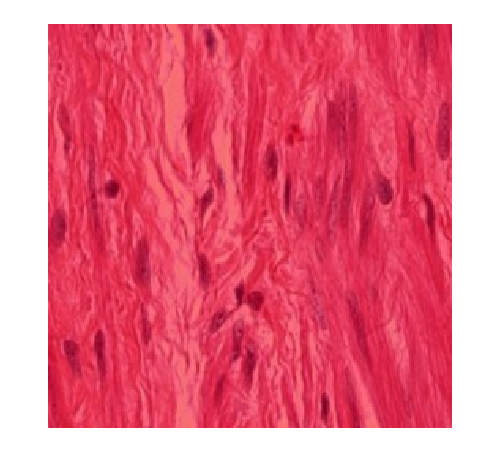

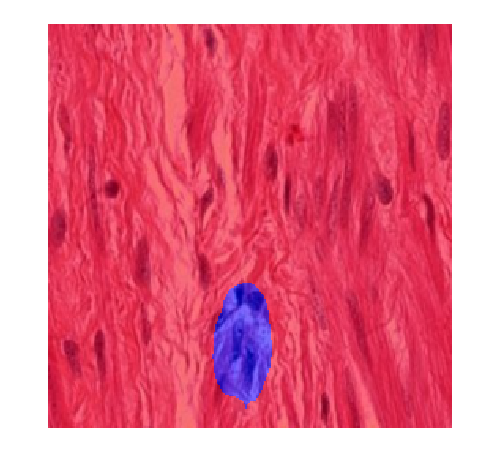

In [25]:
# Visualization the sementic map
visualize.display_sementic(image_crop, gt_sementic_mask_crop,
                            figsize=(8, 8))
visualize.display_sementic(image_crop, pred_mask_crop, 
                            figsize=(8, 8))

In [56]:
print(r['tumor_probs'], tumor_class_gt)

[[  3.01639961e-32   1.00000000e+00]] 0
